# **LDA**

In [ ]:
import numpy as np
import spacy
import random
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [ ]:
df = pd.read_csv('emails.csv') # Datset is downloaded from Kaggle
df.head(5)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
# Dirichlet , hyperparams , tokenizer
Alpha = 0.1
Beta = 0.1
num_topics = 20
sp = spacy.load('en_core_web_sm')

#reproducibility
np.random.seed(42)
random.seed(42)

In [ ]:
def generate_frequencies(data , max_docs = 10000):
  freqs = Counter()
  all_stopwords = sp.Defaults.stop_words
  all_stopwords.add('enron')
  nr_tokens =0

  for doc in data[:max_docs]:
    tokens = sp.tokenizer(doc)
    for token in tokens:
      token_text = token.text.lower()
      if token_text not in all_stopwords and token.is_alpha:
        nr_tokens +=1
        freqs[token_text] +=1

  return freqs

def get_vocab(freqs, freq_threshold = 3):
  vocab ={}
  vocab_idx_str = {}
  vocab_idx = 0

  for word in freqs:
    if freqs[word] >= freq_threshold:
      vocab[word] = vocab_idx
      vocab_idx_str[vocab_idx] = word
      vocab_idx +=1
  return vocab , vocab_idx_str

def tokenize_dataset(data, vocab, max_docs = 10000):
  nr_tokens = 0
  nr_docs = 0
  docs =[]

  for doc in data[:max_docs]:
    tokens = sp.tokenizer(doc)

    if len(tokens)>1:
      doc = []
      for token in tokens:
        token_text = token.text.lower()
        if token_text in vocab:
          doc.append(token_text)
          nr_tokens +=1
      nr_docs +=1
      docs.append(doc)

  print(f"Number of emails: {nr_docs}")
  print(f"Number of tokens: {nr_tokens}")

  # Numericalize

  corpus =[]
  for doc in docs:
     corpus_d = []

     for token in doc:
         corpus_d.append(vocab[token])

     corpus.append(np.asarray(corpus_d))

  return docs, corpus

In [ ]:
data = df['text'].sample(frac = 0.5, random_state=42).values
freqs = generate_frequencies(data, max_docs = 10000)
vocab, vocab_idx_str = get_vocab(freqs)
docs, corpus = tokenize_dataset(data, vocab)
vocab_size = len(vocab)
print(f"Vocab size :{vocab_size}")

Number of emails: 2864
Number of tokens: 348989
Vocab size :10626


In [ ]:
def LDA_collapsed_Gibbs(corpus, num_iter = 200):

  # Initialize counts and z
  Z = [] # topics
  num_docs = len(corpus)
  for doc_idx, doc in enumerate(corpus):
    Zd = np.random.randint(low = 0 , high = num_topics, size = (len(doc)))
    Z.append(Zd)

  ndk = np.zeros((num_docs, num_topics))
  for d in range(num_docs):
      for k in range(num_topics):
           ndk[d , k] = np.sum(Z[d] == k)

  nkw = np.zeros((num_topics, vocab_size))
  for doc_idx, doc in enumerate(corpus):
    for i, word in enumerate(doc):
      topic = Z[doc_idx][i]
      nkw[topic, word] +=1

  nk = np.sum(nkw, axis=1)
  topic_list = [i for i in range(num_topics)]

  # loops

  for _ in tqdm(range(num_iter)):
    for doc_idx, doc in enumerate(corpus):
      for i in range(len(doc)):
        word = doc[i]
        topic = Z[doc_idx][i]

        # remove z_i because conditioned on z_(-i)
        ndk[doc_idx, topic] -=1
        nkw[topic, word] -= 1
        nk[topic] -=1

        p_z = (ndk[doc_idx, :]+Alpha)*(nkw[:, word]+Beta) / (nk[:]+Beta*vocab_size)
        topic = random.choices(topic_list, weights = p_z, k=1)[0]

        # update n parameters
        Z[doc_idx][i] = topic
        ndk[doc_idx, topic] +=1
        nkw[topic, word]+=1
        nk[topic]+=1

  return Z, ndk , nkw , nk

Z, ndk, nkw, nk = LDA_collapsed_Gibbs(corpus)

100%|██████████| 200/200 [18:04<00:00,  5.42s/it]


In [ ]:
phi = nkw / nk.reshape(num_topics, 1) # to get probability distribution

num_words = 10

for k in range(num_topics):
  most_common_words = np.argsort(phi[k])[::-1][:num_words]
  print(f"Topic {k} most common words: ")

  for word in most_common_words:
    print(vocab_idx_str[word])

  print('\n')

Topic 0 most common words: 
com
http
www
email
e
mail
list
subject
information
site


Topic 1 most common words: 
adobe
software
subject
need
pro
business
studio
cs
available
cd


Topic 2 most common words: 
kevin
feedback
subject
s
moore
process
performance
employee
mike
associate


Topic 3 most common words: 
request
subject
vince
com
lng
approval
kaminski
john
gas
pm


Topic 4 most common words: 
com
message
d
x
subject
received
mail
aol
jul
tue


Topic 5 most common words: 
company
s
information
statements
companies
stock
investment
inc
report
media


Topic 6 most common words: 
ect
hou
ees
communications
john
corp
martin
subject
baylor
pm


Topic 7 most common words: 
model
price
data
subject
s
prices
time
market
use
need


Topic 8 most common words: 
edu
rice
summer
subject
vince
kaminski
com
work
jinbaek
know


Topic 9 most common words: 
iris
l
subject
mack
s
credit
model
london
m
v


Topic 10 most common words: 
group
s
new
management
business
risk
services
research
trading
gl

# **LDA using nltk**

In [ ]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [ ]:
## Removing the Punctuation / lower casing

import re

# remove punctuation
df['text'].map(lambda x: re.sub('[,\.!?]', '',x))

# convert the titles to lowercase
df['text'].map(lambda x: x.lower())

df['text'].head()


,text
0,Subject: naturally irresistible your corporate...
1,Subject: the stock trading gunslinger fanny i...
2,Subject: unbelievable new homes made easy im ...
3,Subject: 4 color printing special request add...
4,"Subject: do not have money , get software cds ..."


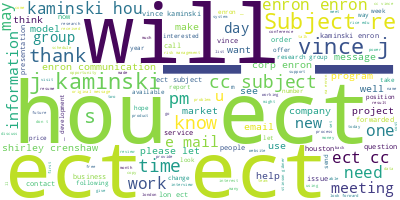

In [ ]:
from wordcloud import WordCloud
long_string = ','.join(list(df['text'].values))

wordcloud = WordCloud(background_color = 'white', max_words = 1000, contour_width = 3, contour_color = 'steelblue')
wordcloud.generate(long_string)

wordcloud.to_image()

**LDA**

In [ ]:
import nltk
import re
import string
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words.update(['from', 'subject', 're', 'edu', 'use'])

def simple_tokenize(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Lowercase and split into words
    tokens = text.lower().split()
    return tokens

def sent_to_words(sentences):
    for sentence in sentences:
        yield simple_tokenize(str(sentence))

def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

data = df['text'].values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['naturally', 'irresistible', 'corporate', 'identity', 'lt', 'really', 'hard', 'recollect', 'company', 'market', 'full', 'suqgestions', 'information', 'isoverwhelminq', 'good', 'catchy', 'logo', 'stylish', 'statlonery', 'outstanding', 'website', 'make', 'task', 'much', 'easier', 'promise', 'havinq', 'ordered', 'iogo', 'company']


In [ ]:
from collections import defaultdict

def create_dictionary(texts):
    word2id = {}
    id2word = {}
    word_count = defaultdict(int)

    for text in texts:
        for word in text:
            word_count[word] += 1

    for i, (word, count) in enumerate(word_count.items()):
        word2id[word] = i
        id2word[i] = word

    return word2id, id2word

def create_corpus(texts, word2id):
    corpus = []
    for text in texts:
        word_freq = defaultdict(int)
        for word in text:
            if word in word2id:
                word_freq[word2id[word]] += 1
        corpus.append(list(word_freq.items()))
    return corpus

word2id, id2word = create_dictionary(data_words)
corpus = create_corpus(data_words, word2id)

print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 2), (21, 2), (22, 1), (23, 2), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

documents = [" ".join(doc) for doc in data_words]

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

num_topics = 10

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([words[i] for i in topic.argsort()[:-top_n - 1:-1]]))

print_topics(lda_model, vectorizer)

doc_topic_distribution = lda_model.transform(X)

print(doc_topic_distribution[0])


Topic #0:
enron vince com wharton request kaminski pm cc thanks business
Topic #1:
power enron dpc state mseb project said government company india
Topic #2:
vince enron ect com kaminski cc hou message pm houston
Topic #3:
com www http information new energy site website cera web
Topic #4:
company market power gas information year companies price investment statements
Topic #5:
adobe save software company pro cs viagra man like good
Topic #6:
enron vince energy research kaminski university risk management rice conference
Topic #7:
email free click money business mail list people make send
Topic #8:
ect enron hou vince cc pm kaminski corp shirley communications
Topic #9:
model price data vince risk var john options prices curve
[0.00102059 0.00102044 0.00102046 0.0010205  0.0010205  0.99081559
 0.00102051 0.00102049 0.00102044 0.00102047]
